<a href="https://colab.research.google.com/github/jithsg/2-Pipeline/blob/main/TuningSensitivity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Detected 20 ICs


/tmp/ipython-input-1808505576.py:89: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.grid(True,ls=':'); plt.legend(); plt.tight_layout(); plt.show()


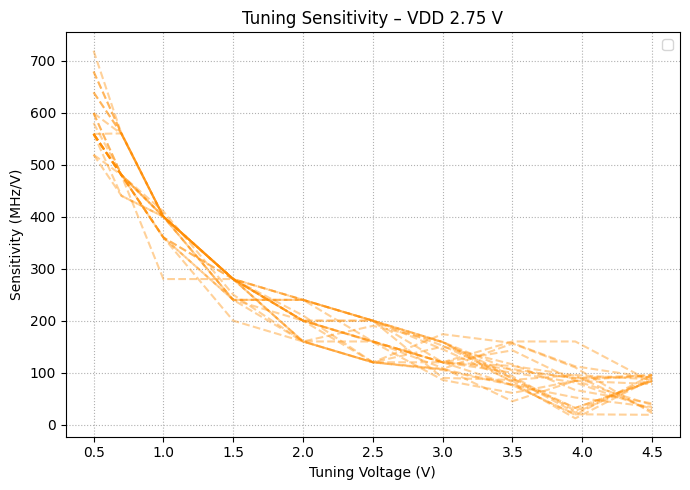

/tmp/ipython-input-1808505576.py:99: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.grid(True,ls=':'); plt.legend(); plt.tight_layout(); plt.show()


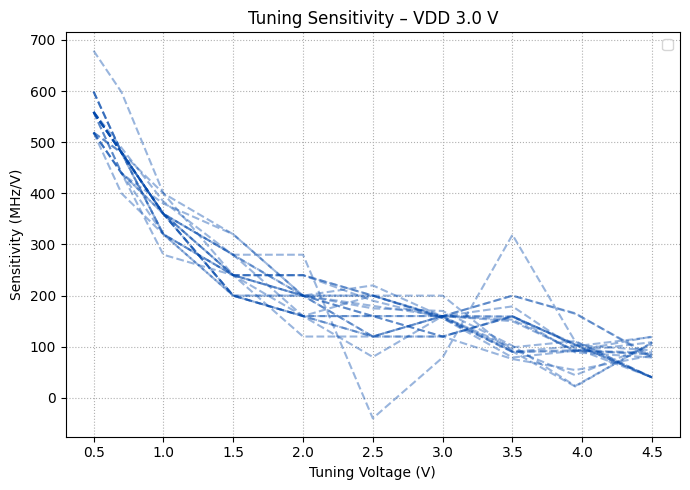

/tmp/ipython-input-1808505576.py:109: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.grid(True,ls=':'); plt.legend(); plt.tight_layout(); plt.show()


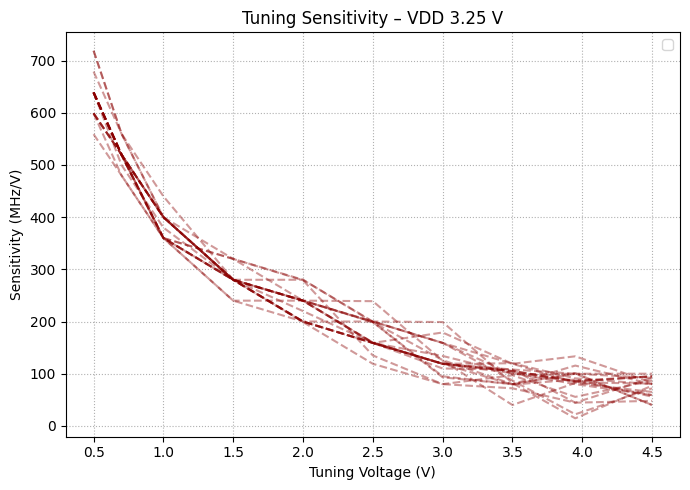

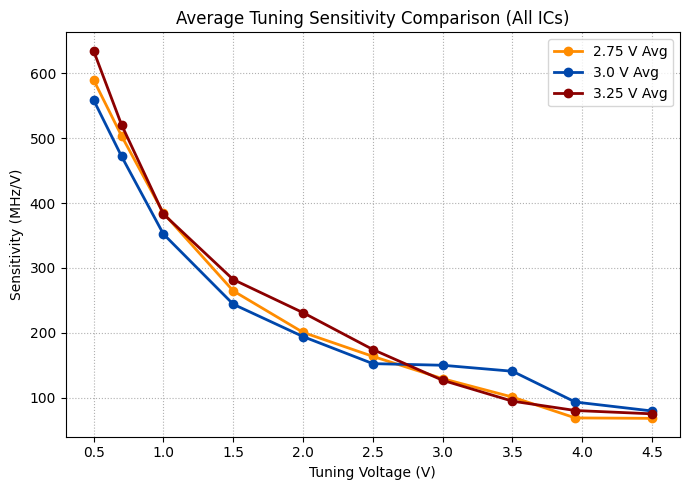

In [2]:
%matplotlib inline
import pandas as pd, numpy as np, matplotlib.pyplot as plt

# -----------------------------
# Load Excel
# -----------------------------
EXCEL_PATH = "Raw_data_A1.xlsx"
SHEET_NAME = "Vdd_variation"
raw = pd.read_excel(EXCEL_PATH, sheet_name=SHEET_NAME, header=None)

# -----------------------------
# Locate IC blocks
# -----------------------------
def find_ic_blocks(df):
    starts=[]
    for r in range(len(df)):
        v=df.iloc[r,0]
        if isinstance(v,str) and v.strip().upper().startswith("IC") and r+4<len(df):
            if ("Vtune" in str(df.iloc[r+1,0]) and
                "2.75" in str(df.iloc[r+2,0]) and
                str(df.iloc[r+3,0]).strip()=="3V" and
                "3.25" in str(df.iloc[r+4,0])):
                starts.append(r)
    return starts

IC_STARTS=find_ic_blocks(raw)
print(f"Detected {len(IC_STARTS)} ICs")

# -----------------------------
# Extract vtune + freq
# -----------------------------
def extract_ic_series(df,r,vt_max=6.0):
    name=str(df.iloc[r,0]).strip()
    vt=pd.to_numeric(df.iloc[r+1,1:],errors='coerce').reset_index(drop=True)
    v275=pd.to_numeric(df.iloc[r+2,1:],errors='coerce').reset_index(drop=True)
    v300=pd.to_numeric(df.iloc[r+3,1:],errors='coerce').reset_index(drop=True)
    v325=pd.to_numeric(df.iloc[r+4,1:],errors='coerce').reset_index(drop=True)
    keep,last=0,None
    for i in range(len(vt)):
        x=vt.iloc[i]
        if not np.isfinite(x) or x>vt_max: break
        if last is not None and x<last-1e-12: break
        keep+=1; last=x
    vt,v275,v300,v325=vt.iloc[:keep],v275.iloc[:keep],v300.iloc[:keep],v325.iloc[:keep]
    mask=np.isfinite(vt)&np.isfinite(v275)&np.isfinite(v300)&np.isfinite(v325)
    return name,vt[mask].to_numpy(),v275[mask].to_numpy(),v300[mask].to_numpy(),v325[mask].to_numpy()

# -----------------------------
# Sensitivity calc
# -----------------------------
pairs=[(1.0,0.0),(1.2,0.2),(1.5,0.5),(2.0,1.0),(2.5,1.5),
       (3.0,2.0),(3.5,2.5),(4.0,3.0),(4.4,3.5),(5.0,4.0)]
midpoints=np.array([(a+b)/2 for a,b in pairs])

def sensitivity(vt,f_ghz):
    vt_s=np.sort(vt); f_s=f_ghz[np.argsort(vt)]
    sens=[]
    for vh,vl in pairs:
        fh=np.interp(vh,vt_s,f_s); fl=np.interp(vl,vt_s,f_s)
        sens.append((fh-fl)*1e3/(vh-vl))   # MHz/V
    return np.array(sens)

# -----------------------------
# Collect sensitivities
# -----------------------------
all275,all300,all325=[],[],[]
for r in IC_STARTS:
    _,vt,v275,v300,v325=extract_ic_series(raw,r)
    all275.append(sensitivity(vt,v275))
    all300.append(sensitivity(vt,v300))
    all325.append(sensitivity(vt,v325))
avg275=np.nanmean(np.vstack(all275),axis=0)
avg300=np.nanmean(np.vstack(all300),axis=0)
avg325=np.nanmean(np.vstack(all325),axis=0)

# -----------------------------
# Color palette
# -----------------------------
c275,c300,c325='#FF8C00','#0047AB','#8B0000'

# -----------------------------
# Plot 1: 2.75 V
# -----------------------------
plt.figure(figsize=(7,5))
for s in all275: plt.plot(midpoints,s,'--',color=c275,alpha=0.4)

plt.title("Tuning Sensitivity – VDD 2.75 V")
plt.xlabel("Tuning Voltage (V)"); plt.ylabel("Sensitivity (MHz/V)")
plt.grid(True,ls=':'); plt.legend(); plt.tight_layout(); plt.show()

# -----------------------------
# Plot 2: 3.0 V
# -----------------------------
plt.figure(figsize=(7,5))
for s in all300: plt.plot(midpoints,s,'--',color=c300,alpha=0.4)

plt.title("Tuning Sensitivity – VDD 3.0 V")
plt.xlabel("Tuning Voltage (V)"); plt.ylabel("Sensitivity (MHz/V)")
plt.grid(True,ls=':'); plt.legend(); plt.tight_layout(); plt.show()

# -----------------------------
# Plot 3: 3.25 V
# -----------------------------
plt.figure(figsize=(7,5))
for s in all325: plt.plot(midpoints,s,'--',color=c325,alpha=0.4)

plt.title("Tuning Sensitivity – VDD 3.25 V")
plt.xlabel("Tuning Voltage (V)"); plt.ylabel("Sensitivity (MHz/V)")
plt.grid(True,ls=':'); plt.legend(); plt.tight_layout(); plt.show()

# -----------------------------
# Plot 4: Average comparison
# -----------------------------
plt.figure(figsize=(7,5))
plt.plot(midpoints,avg275,'o-',color=c275,lw=2,label='2.75 V Avg')
plt.plot(midpoints,avg300,'o-',color=c300,lw=2,label='3.0 V Avg')
plt.plot(midpoints,avg325,'o-',color=c325,lw=2,label='3.25 V Avg')
plt.title("Average Tuning Sensitivity Comparison (All ICs)")
plt.xlabel("Tuning Voltage (V)"); plt.ylabel("Sensitivity (MHz/V)")
plt.grid(True,ls=':'); plt.legend(); plt.tight_layout(); plt.show()